<a href="https://colab.research.google.com/github/A01793509/Equipo_44/blob/main/Avance4_44.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🚀 **Avance 4. Modelos alternativos**: Explorar una gama diversa de técnicas y enfoques con el fin de identificar el de mejor desempeño en el conjunto de datos en cuestión. Encontrar la configuración óptima que maximiza el rendimiento del modelo en una tarea específica.

📑 **Asignatura**: Proyecto Integrador

📘 **Proyecto**: LunchForecast AI: Optimizador de reservas de almuerzos empresariales basado en inteligencia artificial.

📚 **Equipo**: 44

🧑 **Alumnos**:

Alberto José García Porras (Matrícula No. **A01793509**)

Erick Johan Najera Olivero (Matrícula No. **A01793506**)

Carlos Julio León Caicedo (Matrícula No. **A01793947**)

👩 **Profesores**:

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

Dr. Guillermo Mota

📅 Mayo 26 del 2024

In [ ]:
#Importamos las librerías que utilizaremos para la ejecución de la actividad
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import numpy as np
import warnings
import statsmodels.api as sm
from datetime import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import boxcox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor


👣**Obtener Datos**: Cargamos el archivo CSV con la información del consumo del casino desde enero del 2021 hasta marzo del 2024.

In [ ]:
dfCasinoConsumo = pd.read_csv("DatosConsumoCasino.csv",sep=";")
#dfCasinoConsumo = pd.read_csv("Consumo_test.csv",sep=";")
dfCasinoConsumoOriginal = dfCasinoConsumo
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1



---

☝**NOTA:** En este entregable iniciaremos aplicando los ajustes detectados en los entregables anteriores, referentes a la depuración de los datos y la ingeniería de características. Por lo tanto, la creación del baseline solicitando en esta entrega se identificará más adelante en la sección 2 del presente notebook.


---




---


👣 **SECCIÓN 1:** Limpieza y ajuste del conjunto de datos.



---



In [ ]:
# Convierte la columna 'fecha del consumo' a tipo datetime si aún no lo está
dfCasinoConsumo['Fecha Consumo'] = pd.to_datetime(dfCasinoConsumo['Fecha Consumo'], format='%Y-%m-%d', errors='coerce')
#dfCasinoConsumo = dfCasinoConsumo.set_index('Fecha Consumo')
dfCasinoConsumo.head()

,Consecutivo,IdProducto,cod lector,Cod comedor,Identificacion persona,Fecha Consumo,Detalle,Nro empleados,Tipo Empleado,Nivel,Porcentaje apoyo,Invitado,Ing x planta
0,825979,2.0,0,1001,100001,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
1,825980,2.0,0,1001,100002,2021-01-03,ALMUERZO,3486,Administrativo,ANAL,90,0,1
2,825981,2.0,0,1001,100003,2021-01-03,ALMUERZO,3486,Operativo,OPER,0,0,1
3,825982,2.0,1,1001,100004,2021-01-03,ALMUERZO,3486,Operativo,OPER,90,0,1
4,825983,2.0,0,1001,100005,2021-01-03,ALMUERZO,3486,Administrativo,OPER,0,0,1


In [ ]:
#En el análisis, habíamos notado que existían valores de 'ALMUERZO' en minúsculas en el campo 'DETALLE'
#Por lo anterior, procederemos a pasar a mayúsculas el contenido de la columna antes de proceder con el borrado
dfCasinoConsumo['Detalle'] = dfCasinoConsumo['Detalle'].str.upper()

#Filtramos el dataFrame para conservar solo las filas donde 'DETALLE' es igual a 'ALMUERZO' y lo guardamos en un
#nuevo dataframe para evitar SettingWithCopyWarning
dfCasinoAlmuerzos = dfCasinoConsumo[dfCasinoConsumo['Detalle'] == 'ALMUERZO'].copy()

In [ ]:
#Eliminamos las columnas que no consideramos relevantes según hallazgos en la fase de exploración
dfCasinoConsumo=dfCasinoConsumo.drop(columns=['Consecutivo', 'Detalle','IdProducto', 'cod lector', 'Cod comedor', 'Identificacion persona', 'Invitado','Ing x planta','Nro empleados','Nivel'])
dfCasinoConsumo.head()

,Fecha Consumo,Tipo Empleado,Porcentaje apoyo
0,2021-01-03,Operativo,0
1,2021-01-03,Administrativo,90
2,2021-01-03,Operativo,0
3,2021-01-03,Operativo,90
4,2021-01-03,Administrativo,0


**pd.get_dummies():** Esta función se utilizó para convertir las variables categóricas Tipo Empleado y Porcentaje apoyo en un conjunto de variables indicadoras (también llamadas variables dummy). Es una técnica comúnmente usada en la preparación de datos para modelos de aprendizaje automático, particularmente útil cuando se trata con modelos que requieren entradas numéricas exclusivamente.

In [ ]:
#Procedemos a realizar la codificación de las columnas categóricas
dfCasinoAlmuerzosCodificado = pd.get_dummies(dfCasinoConsumo, columns=['Tipo Empleado',  'Porcentaje apoyo'])
dfCasinoAlmuerzosCodificado.head()

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,False,False,True,True,False,False,False
1,2021-01-03,True,False,False,False,False,True,False
2,2021-01-03,False,False,True,True,False,False,False
3,2021-01-03,False,False,True,False,False,True,False
4,2021-01-03,True,False,False,True,False,False,False


In [ ]:
#Para que el modelo que desarrollaremos más adelante funcione de una mejor manera,
#procederemos a convertir los valores booleanos a números.
#Recorremos todas las columnas y al identificar una booleana, la convertiremos en número.
for col in dfCasinoAlmuerzosCodificado.columns:
    if dfCasinoAlmuerzosCodificado[col].dtype == bool:
        dfCasinoAlmuerzosCodificado[col] = dfCasinoAlmuerzosCodificado[col].astype(int)

dfCasinoAlmuerzosCodificado.head(5)

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0


In [ ]:
dfCasinoAlmuerzosCodificado

,Fecha Consumo,Tipo Empleado_Administrativo,Tipo Empleado_Aprendices,Tipo Empleado_Operativo,Porcentaje apoyo_0,Porcentaje apoyo_30,Porcentaje apoyo_90,Porcentaje apoyo_100
0,2021-01-03,0,0,1,1,0,0,0
1,2021-01-03,1,0,0,0,0,1,0
2,2021-01-03,0,0,1,1,0,0,0
3,2021-01-03,0,0,1,0,0,1,0
4,2021-01-03,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
884610,2024-03-21,0,0,1,0,0,1,0
884611,2024-03-22,0,0,1,0,0,1,0
884612,2024-03-23,0,0,1,0,0,1,0
884613,2024-03-26,0,0,1,0,0,1,0


In [ ]:
# Agrupar por 'Fecha' y realizar las agregaciones necesarias para olumnas codificadas como dummies con la función agg()
dfAlmuerzoAgrupado = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').agg({
    'Tipo Empleado_Administrativo': 'sum',
    'Tipo Empleado_Aprendices': 'sum',
    'Tipo Empleado_Operativo': 'sum',
    'Porcentaje apoyo_0': 'sum',
    'Porcentaje apoyo_30': 'sum',
    'Porcentaje apoyo_90': 'sum',
    'Porcentaje apoyo_100': 'sum'
}).reset_index()

In [ ]:
# Agregar una nueva columna con el conteo de registros por fecha
dfAlmuerzoAgrupado['Cantidad Almuerzos'] = dfCasinoAlmuerzosCodificado.groupby('Fecha Consumo').size().values

In [ ]:
# Convertir fechas a formato datetime
dfAlmuerzoAgrupado['Fecha Consumo'] = pd.to_datetime(dfAlmuerzoAgrupado['Fecha Consumo'])

# Nos aseguramos de que el DataFrame esté ordenado por fecha para que cualquier operación
# o visualización a realizar con los datos siga el orden cronológico correcto.
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.sort_values('Fecha Consumo')

# Configurar la fecha como el índice
dfAlmuerzoAgrupado.set_index('Fecha Consumo', inplace=True)
dfAlmuerzoAgrupado.index

DatetimeIndex(['2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10',
               '2021-01-11', '2021-01-12',
               ...
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27', '2024-03-28', '2024-03-29',
               '2024-03-30', '2024-03-31'],
              dtype='datetime64[ns]', name='Fecha Consumo', length=1181, freq=None)

In [ ]:
fecha_inicio = dfAlmuerzoAgrupado.index.min()
fecha_fin = dfAlmuerzoAgrupado.index.max()
rango_fechas = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='D')
# Reindexar el DataFrame
dfAlmuerzoAgrupado = dfAlmuerzoAgrupado.reindex(rango_fechas)

dfAlmuerzoAgrupado.fillna(0,inplace=True)

# Seleccionar el valor de una columna específica en una fecha específica usando at
# Especifica la fecha que deseas filtrar
fecha_especifica = '2022-01-01'

# Convertir la fecha específica a tipo datetime
fecha_especifica = pd.to_datetime(fecha_especifica)

# Filtrar el DataFrame para la fecha específica
try:
    registro_filtrado = dfAlmuerzoAgrupado.loc[fecha_especifica]
    print(f"Registro para la fecha {fecha_especifica.date()}:\n{registro_filtrado}")
except KeyError:
    print(f"No hay registros para la fecha {fecha_especifica.date()}")

dfAlmuerzoAgrupado.info()


Registro para la fecha 2022-01-01:
Tipo Empleado_Administrativo    0.0
Tipo Empleado_Aprendices        0.0
Tipo Empleado_Operativo         0.0
Porcentaje apoyo_0              0.0
Porcentaje apoyo_30             0.0
Porcentaje apoyo_90             0.0
Porcentaje apoyo_100            0.0
Cantidad Almuerzos              0.0
Name: 2022-01-01 00:00:00, dtype: float64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1184 entries, 2021-01-03 to 2024-03-31
Freq: D
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Tipo Empleado_Administrativo  1184 non-null   float64
 1   Tipo Empleado_Aprendices      1184 non-null   float64
 2   Tipo Empleado_Operativo       1184 non-null   float64
 3   Porcentaje apoyo_0            1184 non-null   float64
 4   Porcentaje apoyo_30           1184 non-null   float64
 5   Porcentaje apoyo_90           1184 non-null   float64
 6   Porcentaje apoyo_100      

In [ ]:
# Variable endógena (consumo)
dfendog = dfAlmuerzoAgrupado['Cantidad Almuerzos']

# Variables exógenas
dfexog = dfAlmuerzoAgrupado[['Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Tipo Empleado_Administrativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(dfAlmuerzoAgrupado) * 0.7)
train_endog1 = dfendog[:train_size]
test_endog1 = dfendog[train_size:]

train_exog = dfexog[:train_size]
test_exog = dfexog[train_size:]

In [ ]:
train_endog = train_endog1.to_frame()
test_endog = test_endog1.to_frame()


---


# 🔖 **Rúbrica - Criterio: Comparativa**


---



---

📚 Basados en la investigación realizada referente a los modelos recomendados para la predicción de la variable objetivo en función de un conjunto de datos con componentes estacionales y variables exógenas, utilizaremos los siguientes modelos para realizar la comparación y seleccionar los dos que nos muestren el mejor rendimiento:
* SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors)
* ARIMA (AutoRegressive Integrated Moving Average)
* Regresión Lineal (Linear Regression)
* Árbol de Regresión (Regression Tree)
* Redes Neuronales (Neural Networks)
* SVM (Support Vector Machines)

De igual forma, utilizaremos el dataframe '**dfmetricas**' para almacenar los rendimientos de las métricas clave de cada modelo y así realizar una comparación objetiva al final del ejercicio.


---

In [ ]:
#Creamos el dataframe para almacenar las diferentes metricas calculadas para cada uno de los 6 modelos
data  = {'Modelo': ['SARIMAX','ARIMA','REGRESIÓN LINEAL','ARBOL DE REGRESIÓN','REDES NEURONALES','SVM'],'Metrica 1': ['WMAE','MAE','MSE','MSE','MBE','MAE'],'Valor 1':[0,0,0,0,0,0],'Metrica 2': ['MBE','MAPE','R2','R2','LOSS','WMAE'],'Valor 2':[0,0,0,0,0,0] }
dfmetricas = pd.DataFrame(data)
print("*******************************************************************************")
print("Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:")
print("*******************************************************************************")

dfmetricas

*******************************************************************************
Esta será nuestra tabla comparativa para evaluar el rendimiento de los modelos:
*******************************************************************************


,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,0,MBE,0
1,ARIMA,MAE,0,MAPE,0
2,REGRESIÓN LINEAL,MSE,0,R2,0
3,ARBOL DE REGRESIÓN,MSE,0,R2,0
4,REDES NEURONALES,MBE,0,LOSS,0
5,SVM,MAE,0,WMAE,0




---


👣**Creación de Modelos**: Iniciamos con la creación y ejecución de los modelos mencionados.



---


🦾 **Modelo 1: SARIMAX**


---



In [ ]:
#Definimos los parámetros a utilizar en SARIMAX siguiendo los hallazgos de los entregables anteriores
p, d, q = 1, 2, 1
P, D, Q, s = 1, 1, 1, 12 #Estos serán nuestros parámetros estacionales

#Entrenamos el modelo
Modelo_SARIMAX = sm.tsa.SARIMAX(train_endog, exog=train_exog, order=(p, d, q), seasonal_order=(P, D, Q, s))
Resultados_SARIMAX = Modelo_SARIMAX.fit()

#Observamos los datos de resumen del modelo
print(Resultados_SARIMAX.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                 Cantidad Almuerzos   No. Observations:                  828
Model:             SARIMAX(1, 2, 1)x(1, 1, 1, 12)   Log Likelihood                   4.920
Date:                            Sun, 26 May 2024   AIC                             14.160
Time:                                    23:07:43   BIC                             70.584
Sample:                                01-03-2021   HQIC                            35.818
                                     - 04-10-2023                                         
Covariance Type:                              opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Tipo Empleado_Aprendices         0.5714   6.08e-11    9.4e+09      0.000      

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


In [ ]:
#Definimos el rango de fechas en nuestro conjunto de pruebas para la predicción con el modelo
Fecha_Inicio = test_endog.index[0]  #Fecha desde
Fecha_Fin =  test_endog.index[-1]  #Fecha hasta

In [ ]:
#Realizamos las predicciones
Prediccion_SARIMAX = Resultados_SARIMAX.get_prediction(start=Fecha_Inicio, end=Fecha_Fin, exog=test_exog)
Prediccion_Final_SARIMAX = Prediccion_SARIMAX.predicted_mean

#Definimos los intervalos de confianza
Prediccion_CI_SARIMAX = Prediccion_SARIMAX.conf_int()


In [ ]:
#Visualizamos las predicciones generadas con el modelo SARIMAX, para ello creamos un dataframe comparando
#las predicciones con los datos reales.
dfComparativoPredSARIMAX = pd.concat([test_endog, Prediccion_Final_SARIMAX], axis=1)
dfComparativoPredSARIMAX.columns = ['Real', 'Predicción']
print("******************************************************")
print("Las predicciones generadas con el modelo SARIMAX son:")
print("******************************************************")
dfComparativoPredSARIMAX

******************************************************
Las predicciones generadas con el modelo SARIMAX son:
******************************************************


,Real,Predicción
2023-04-11,700.0,716.137280
2023-04-12,728.0,744.198175
2023-04-13,747.0,763.255911
2023-04-14,707.0,723.314906
2023-04-15,608.0,624.374185
...,...,...
2024-03-27,1173.0,1216.317194
2024-03-28,672.0,715.412168
2024-03-29,612.0,655.507419
2024-03-30,593.0,636.602944


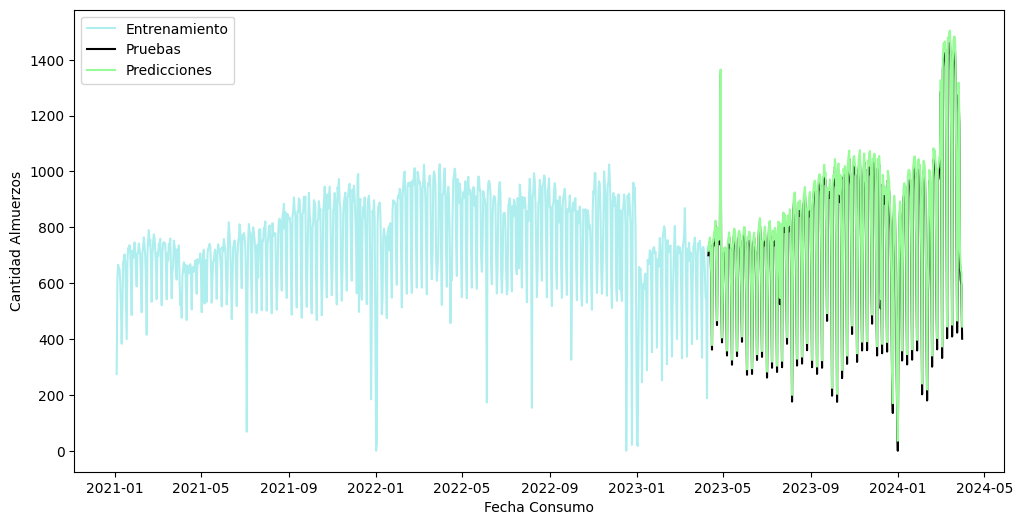

In [ ]:
#Graficamos las predicciones para realizar un análisis visual
plt.figure(figsize=(12, 6))
plt.plot(train_endog, label='Entrenamiento', color='paleturquoise')
plt.plot(test_endog, label='Pruebas', color='black')
plt.plot(Prediccion_Final_SARIMAX, label='Predicciones', color='palegreen')
plt.fill_between(Prediccion_CI_SARIMAX.index, Prediccion_CI_SARIMAX.iloc[:, 0], Prediccion_CI_SARIMAX.iloc[:, 1], color='k', alpha=0.2)
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.legend()
plt.show()

---

🔢**Métricas:** calcularemos a continuación las diferentes métricas recomendadas para el modelo SARIMAX. Sin embargo, nos enfocaremos en las métricas MBE y WMAE definidas en nuestro entregable anterior como parámetros propuesto para afinamiento del modelo.

---

In [ ]:
#Calculamos MAE y RMSE
MAE = mean_absolute_error(test_endog, Prediccion_Final_SARIMAX)
RMSE = np.sqrt(mean_squared_error(test_endog, Prediccion_Final_SARIMAX))

#Calculamos MBE
mbe = (Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos']).mean()

#Calculamos WMAE
Pesos = np.ones_like(test_endog['Cantidad Almuerzos'])
absolute_errors = np.abs(Prediccion_Final_SARIMAX - test_endog['Cantidad Almuerzos'])
wmae = np.sum(Pesos * absolute_errors) / np.sum(Pesos)

print(f'**********************************************')
print(f'Métricas para el modelo SARIMAX (statsmodels):')
print(f'**********************************************')
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'MBE: {mbe}')
print(f'WMAE: {wmae}')

**********************************************
Métricas para el modelo SARIMAX (statsmodels):
**********************************************
MAE: 28.84379472073682
RMSE: 29.931063054187177
MBE: 28.84379472073682
WMAE: 28.84379472073682


In [ ]:
#Actualizamos las metricas obtenidas del modelo 1 en el dataframe
dfmetricas.at[0,'Valor 1'] = wmae
dfmetricas.at[0,'Valor 2'] = mbe



---


🦾 **Modelo 2: ARIMA**


---



In [ ]:
#Instanciamos nuestro modelo ARIMA
Modelo_ARIMA = ARIMA(train_endog['Cantidad Almuerzos'], order=(p, d, q))

#Entrenamos el modelo
Resultados_ARIMA = Modelo_ARIMA.fit()

#Realizamos las predicciones
Predicciones_ARIMA = Resultados_ARIMA.get_forecast(steps=len(test_endog))
Predicciones_ARIMA_Final = Predicciones_ARIMA.predicted_mean
Intervalo_Confianza_ARIMA = Predicciones_ARIMA.conf_int()

print("***************************************************")
print("Las predicciones generadas con el modelo ARIMA son:")
print("***************************************************")
print(Predicciones_ARIMA_Final)
print("******************************************************")
print("A continuación visualizamos el intervalo de confianza:")
print("******************************************************")
Intervalo_Confianza_ARIMA


***************************************************
Las predicciones generadas con el modelo ARIMA son:
***************************************************
2023-04-11    703.073733
2023-04-12    705.174863
2023-04-13    705.595673
2023-04-14    706.107483
2023-04-15    706.614364
                 ...    
2024-03-27    882.590119
2024-03-28    883.097254
2024-03-29    883.604388
2024-03-30    884.111523
2024-03-31    884.618658
Freq: D, Name: predicted_mean, Length: 356, dtype: float64
******************************************************
A continuación visualizamos el intervalo de confianza:
******************************************************


,lower Cantidad Almuerzos,upper Cantidad Almuerzos
2023-04-11,363.843554,1042.303911
2023-04-12,237.958911,1172.390815
2023-04-13,137.797819,1273.393527
2023-04-14,52.874149,1359.340817
2023-04-15,-22.278986,1435.507715
...,...,...
2024-03-27,-6324.875853,8090.056091
2024-03-28,-6337.661971,8103.856479
2024-03-29,-6350.441000,8117.649777
2024-03-30,-6363.212978,8131.436024


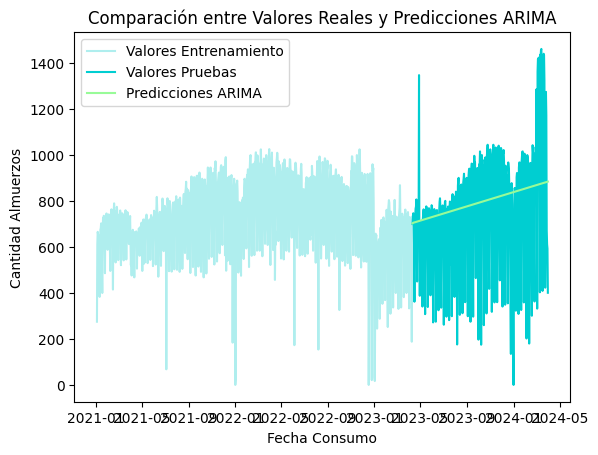

In [ ]:
#Graficamos las predicciones para realizar un análisis visual
plt.plot(train_endog, label='Valores Entrenamiento', color='paleturquoise')
plt.plot(test_endog, label='Valores Pruebas', color='darkturquoise')
plt.plot(Predicciones_ARIMA_Final, label='Predicciones ARIMA', color='palegreen')

#Agregamos etiquetas y leyendas
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.title('Comparación entre Valores Reales y Predicciones ARIMA')
plt.legend()

#Visualizamos la gráfica
plt.show()


---

🔢**Métricas:** calcularemos a continuación las métricas MAE y MAPE para el modelo ARIMA.

---

In [ ]:
#Calculamos los errores absolutos (MAE) entre las predicciones y los valores reales
mae = mean_absolute_error(test_endog, Predicciones_ARIMA_Final)

#Calculamos el MAPE
#Antes eliminamos los valores en cero para evitar errores en su cálculo
test_endog_sin_ceros = test_endog[test_endog['Cantidad Almuerzos'] != 0]
#Calculamos el Error Absoluto Porcentual (APE)
APE = np.abs((test_endog_sin_ceros['Cantidad Almuerzos'] - Predicciones_ARIMA_Final) / test_endog_sin_ceros['Cantidad Almuerzos']) * 100
#Finalmente calculamos el MAPE con el promedio de APEs calculado previamente
MAPE = np.mean(APE)

print(f'**********************************************')
print(f'Métricas para el modelo ARIMA:')
print(f'**********************************************')
print(f'MAE: {mae}')
print(f'MAPE: {MAPE}')



**********************************************
Métricas para el modelo ARIMA:
**********************************************
MAE: 195.2105378792586
MAPE: 39.895472854577044


In [ ]:
#Actualizamos las metricas obtenidas del modelo 2 en el dataframe
dfmetricas.at[1,'Valor 1'] = mae
dfmetricas.at[1,'Valor 2'] = MAPE



---


🦾 **Modelo 3: REGRESIÓN LINEAL**


---


In [ ]:
#Instanciamos nuestro modelo de regresión lineal
Modelo_REGRESION = LinearRegression()

#Entrenamos el modelo utilizando los datos de entrenamiento
Modelo_REGRESION.fit(train_exog, train_endog)

LinearRegression()

In [ ]:
#Realizamos las predicciones con nuestro conjunto de pruebas
Predicciones_REGRESION_LINEAL = Modelo_REGRESION.predict(test_exog)

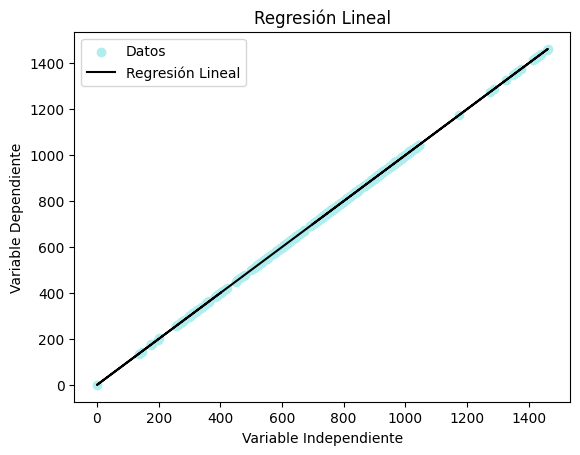

In [ ]:
#Graficamos las predicciones para realizar un análisis visual
plt.scatter(test_endog, Predicciones_REGRESION_LINEAL, color='paleturquoise', label='Datos')
plt.plot(test_endog, Modelo_REGRESION.predict(test_exog), color='black', label='Regresión Lineal')
plt.xlabel('Variable Independiente')
plt.ylabel('Variable Dependiente')
plt.title('Regresión Lineal')
plt.legend()

# Mostrar la gráfica
plt.show()


---

🔢**Métricas:** calcularemos a continuación las métricas MSE y R² para el modelo de Regresión Lineal.

---

In [ ]:
#Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(test_endog, Predicciones_REGRESION_LINEAL)

#Calculamos el coeficiente de determinación (R²)
r2 = r2_score(test_endog, Predicciones_REGRESION_LINEAL)

print(f'*********************************************')
print(f'Métricas para el modelo  de Regresión Lineal:')
print(f'*********************************************')
print(f'MSE: {mse}')
print(f'R²: {r2}')

*********************************************
Métricas para el modelo  de Regresión Lineal:
*********************************************
MSE: 4.407920739185151e-26
R²: 1.0


In [ ]:
#Actualizamos las metricas obtenidas del modelo 3 en el dataframe
dfmetricas.at[2,'Valor 1'] = mse
dfmetricas.at[2,'Valor 2'] = r2



---


🦾 **Modelo 4: ÁRBOL DE REGRESIÓN**


---


In [ ]:
#Antes de instanciar este modelo, debemos realizar una preparación de nuestro conjunto de datos.
#Concatenamos los dataframes de las variables exogenas y endogena definidas para entrenamiento.
dfConcatenadoTrain = pd.concat([dfexog, dfendog], axis=1)

#Asignamos a "X" las variables exogenas y a "Y" la variable endogena
X = dfConcatenadoTrain.drop(columns=["Cantidad Almuerzos"])
y = dfConcatenadoTrain["Cantidad Almuerzos"]

#Dividimos nuestros datos en entrenamiento y pruebas
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Ahora sí, instanciamos nuestro modelo de árbol de regresión
Modelo_ARBOL_REGRESION = DecisionTreeRegressor()

#Entrenamos nuestro modelo utilizando los datos de entrenamiento
Modelo_ARBOL_REGRESION.fit(X_entrenamiento, y_entrenamiento)

DecisionTreeRegressor()

In [ ]:
#Realizamos las predicciones en el conjunto de pruebas
Predicciones_ARBOL_REGRESION = Modelo_ARBOL_REGRESION.predict(X_prueba)

#Visualizamos las predicciones
print("*******************************************************************")
print("Las predicciones generadas con el modelo de Árbol de Regresión son:")
print("*******************************************************************")
Predicciones_ARBOL_REGRESION

*******************************************************************
Las predicciones generadas con el modelo de Árbol de Regresión son:
*******************************************************************


array([ 891.,  866.,  690.,  716., 1012.,  973.,  624.,  525.,  897.,
        843.,  770.,  173.,  668.,    0.,  801.,  772.,  810.,  857.,
        724.,  519.,  904.,  634.,  658.,  800.,  580.,  845.,  897.,
        536.,  515.,  850.,  701.,  706.,  958.,  897.,  866.,  707.,
        360.,  986.,  867.,  948.,  841.,  547.,  944.,  922.,  913.,
        508.,  878.,  968.,  546.,  544.,  729.,  564.,  836.,  772.,
        812.,  682.,  990.,  550.,  714.,  770.,  580.,  563.,  705.,
        924.,  720.,  383.,  704., 1031.,  953.,  892.,  970.,  764.,
        654.,  701.,  932.,  780.,  929.,  706.,  918.,  663.,  180.,
        582.,  851.,  743.,  891.,  787.,  468.,  841.,  965.,  631.,
        587.,  941.,  939.,  918.,  656.,  650.,  715.,  922.,  339.,
        993.,  624.,  530.,  565.,  701.,  866.,  737.,  949.,  301.,
        790.,  887.,  701.,  944.,  739.,  918.,  970.,  746.,  888.,
       1045.,  742.,  560.,  977.,  495.,  528.,  905.,  826.,  650.,
        618.,  684.,

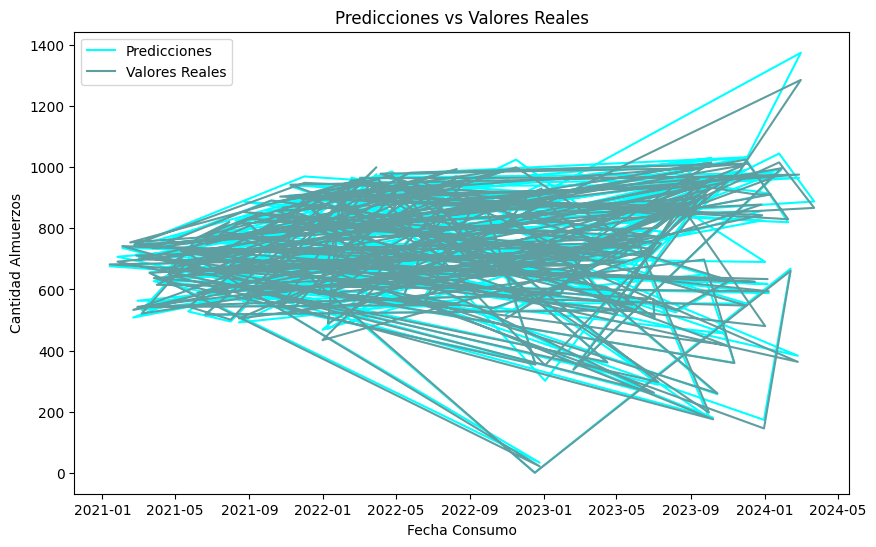

In [ ]:
#Graficamos las predicciones para realizar un análisis visual
plt.figure(figsize=(10, 6))
plt.plot(y_prueba.index, Predicciones_ARBOL_REGRESION, label='Predicciones', color='cyan')
plt.plot(y_prueba.index, y_prueba, label='Valores Reales', color='cadetblue')

#Configuramos etiquetas y títulos
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.title('Predicciones vs Valores Reales')
plt.legend()
plt.show()

---

🔢**Métricas:** calcularemos a continuación las métricas MSE y R² para el modelo de Árbol de Regresión.

---

In [ ]:
#Calculamos el error cuadrático medio (MSE)
mse = mean_squared_error(y_prueba, Predicciones_ARBOL_REGRESION)
#Calculamos el R^2
r2 = r2_score(y_prueba, Predicciones_ARBOL_REGRESION)

print(f'**********************************************')
print(f'Métricas para el modelo de Árbol de Regresión:')
print(f'**********************************************')
print(f'MSE: {mse}')
print(f'R²: {r2}')

**********************************************
Métricas para el modelo de Árbol de Regresión:
**********************************************
MSE: 483.21940928270044
R²: 0.9873204219516685


In [ ]:
#Actualizamos las metricas obtenidas del modelo 4 en el dataframe
dfmetricas.at[3,'Valor 1'] = mse
dfmetricas.at[3,'Valor 2'] = r2


---


🦾 **Modelo 5: REDES NEURONALES**


---

In [ ]:
#Antes de construir el modelo, debemos preparar los datos adicionando una nueva columna de fecha
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado
dfAlmuerzoAgrupado1['FechaO'] = dfAlmuerzoAgrupado1.index.map(pd.Timestamp.toordinal)

#Separamos las variables exógenas (X) de la endógena (y)
X = dfAlmuerzoAgrupado1[['FechaO', 'Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

#Dividimos los datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Finalmente normalizamos los datos antes de instanciar el modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
#Instanciamos nuestro modelo de Redes Neuronales
Modelo_REDES_NEURONALES = Sequential()
Modelo_REDES_NEURONALES.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
Modelo_REDES_NEURONALES.add(Dense(32, activation='relu'))
Modelo_REDES_NEURONALES.add(Dense(1))

#Entrenamos nuestro modelo
Modelo_REDES_NEURONALES.compile(optimizer='adam', loss='mean_squared_error')
Modelo_REDES_NEURONALES.fit(X_train_scaled, y_train, epochs=50, batch_size=10, verbose=1)

Epoch 1/50
95/95 [==============================] - 1s 2ms/step - loss: 597752.0625
Epoch 2/50
95/95 [==============================] - 0s 2ms/step - loss: 536559.1250
Epoch 3/50
95/95 [==============================] - 0s 2ms/step - loss: 358266.6875
Epoch 4/50
95/95 [==============================] - 0s 2ms/step - loss: 146170.9219
Epoch 5/50
95/95 [==============================] - 0s 2ms/step - loss: 49973.5000
Epoch 6/50
95/95 [==============================] - 0s 2ms/step - loss: 25505.2637
Epoch 7/50
95/95 [==============================] - 0s 2ms/step - loss: 17329.1348
Epoch 8/50
95/95 [==============================] - 0s 2ms/step - loss: 12957.2031
Epoch 9/50
95/95 [==============================] - 0s 2ms/step - loss: 10209.4443
Epoch 10/50
95/95 [==============================] - 0s 2ms/step - loss: 8458.5996
Epoch 11/50
95/95 [==============================] - 0s 2ms/step - loss: 7252.9683
Epoch 12/50
95/95 [==============================] - 0s 2ms/step - loss: 6383.9927


In [ ]:
#Ejecutamos las predicciones con nuestros datos de pruebas
Predicciones_REDES_NEURONALES = Modelo_REDES_NEURONALES.predict(X_test_scaled)

#Creamos un dataframe para comparar los datos reales con las predicciones ejecutadas
dfComparacionPrediccionesRN = pd.DataFrame({'Real': y_test, 'Predicción': Predicciones_REDES_NEURONALES.flatten()})

#Visualizamos las predicciones
print("*****************************************************************")
print("Las predicciones generadas con el modelo de Redes Neuronales son:")
print("*****************************************************************")
dfComparacionPrediccionesRN

8/8 [==============================] - 0s 2ms/step
*****************************************************************
Las predicciones generadas con el modelo de Redes Neuronales son:
*****************************************************************


,Real,Predicción
2021-11-18,908.0,911.799622
2023-08-17,872.0,852.966125
2024-01-02,480.0,516.046875
2021-03-30,701.0,713.606384
2023-09-20,997.0,932.877930
...,...,...
2021-05-22,660.0,663.212708
2023-11-12,359.0,361.569550
2023-09-23,698.0,717.010864
2021-08-15,505.0,485.316528


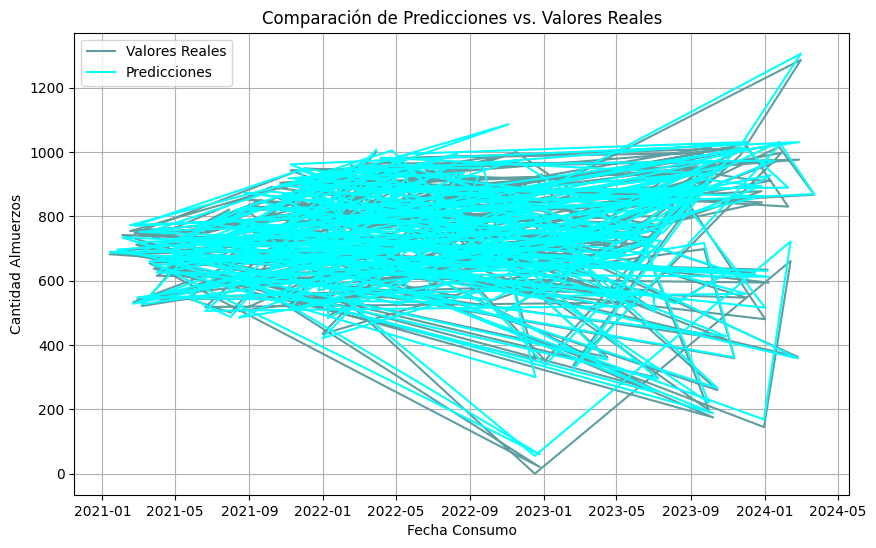

In [ ]:
#Graficamos las predicciones para realizar un análisis visual
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Valores Reales', color='cadetblue')
plt.plot(y_test.index, Predicciones_REDES_NEURONALES.flatten(), label='Predicciones', color='cyan')
#Ajustamos las etiquetas del gráfico
plt.title('Comparación de Predicciones vs. Valores Reales')
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.legend()
plt.grid(True)
plt.show()

---

🔢**Métricas:** calcularemos a continuación las métricas MBE y Loss (perdidas) para el modelo de Redes Neuronales.

---

In [ ]:
#Calculamos Loss
Perdidas = Modelo_REDES_NEURONALES.evaluate(X_test_scaled, y_test)
#Calculamos MBE
mbe = np.mean(Predicciones_REDES_NEURONALES.flatten() - y_test)

print(f'********************************************')
print(f'Métricas para el modelo de Redes Neuronales:')
print(f'********************************************')
print(f'Loss: {Perdidas}')
print(f'MBE: {mbe}')

8/8 [==============================] - 0s 3ms/step - loss: 534.5259
********************************************
Métricas para el modelo de Redes Neuronales:
********************************************
Loss: 534.5259399414062
MBE: -3.2225140760719526


In [ ]:
#Actualizamos las metricas obtenidas del modelo 5 en el dataframe
dfmetricas.at[4,'Valor 1'] = mbe
dfmetricas.at[4,'Valor 2'] = Perdidas


---


🦾 **Modelo 6: SUPPORT VECTOR MACHINE (SVM)**


---

In [ ]:
#Antes de iniciar con nuestro modelo SVM preparamos los datos
dfAlmuerzoAgrupado1 = dfAlmuerzoAgrupado

#Separamos las variables exógenas (X) de la endógena (y)
X = dfAlmuerzoAgrupado1[['Tipo Empleado_Administrativo', 'Tipo Empleado_Aprendices', 'Tipo Empleado_Operativo','Porcentaje apoyo_0','Porcentaje apoyo_30','Porcentaje apoyo_90','Porcentaje apoyo_100']]
y = dfAlmuerzoAgrupado1['Cantidad Almuerzos']

#Dividimos nuestros datos en entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#Ahora vamos a crear un pipeline para escalar los datos y entrenar así el modelo SVM
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))

#Entrenamos el modelo con los datos de entrenamiento
pipeline.fit(X_train, y_train)

#Realizamos las predicciones con los datos de prueba
Predicciones_SVM = pipeline.predict(X_test)

#Visualizamos las predicciones de nuestro modelo SVM
print("*************************************************")
print("Las predicciones generadas con el modelo SVM son:")
print("*************************************************")
Predicciones_SVM

*************************************************
Las predicciones generadas con el modelo SVM son:
*************************************************


array([ 908.1212929 ,  872.80912402,  613.66343547,  701.02228932,
        996.52656515,  978.04630414,  629.62075522,  538.62041687,
        905.48509759,  828.73137137,  771.57785892,  157.26936495,
        663.40911762,  135.64835427,  809.71442562,  747.91462006,
        800.13230545,  876.66428724,  727.88321812,  514.11011979,
        907.70648486,  621.12465489,  651.86996511,  787.11887666,
        575.25099339,  867.92859911,  879.07673093,  530.30759789,
        517.25606465,  815.33077481,  691.08017167,  697.93616518,
        976.74657377,  896.16525402,  866.38105822,  691.09537963,
        363.29686861,  970.98147412,  887.73570948,  946.78503533,
        841.22270242,  548.24119006,  940.63632728,  911.00824413,
        909.76313417,  533.7102586 ,  888.42156618,  962.35980413,
        542.8736136 ,  548.66010438,  724.88986066,  550.70751642,
        848.8816008 ,  771.95702216,  821.06290957,  685.99555025,
       1006.36628204,  543.67367717,  710.80242416,  762.85651

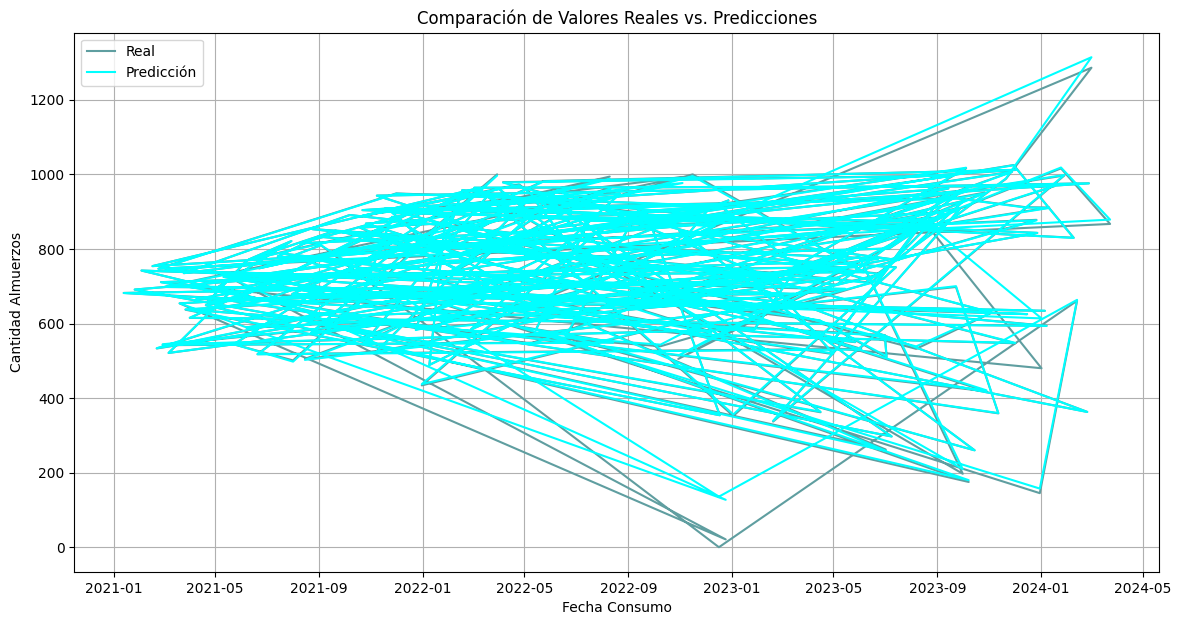

In [ ]:
#Graficamos las predicciones para realizar un análisis visual, pero antes
#crearemos un dataframe para facilitar la visualización.
Resultados_SVM = pd.DataFrame({'Valores Reales': y_test, 'Predicciones': Predicciones_SVM}, index=y_test.index)

# Graficamos los valores reales versus las predicciones
plt.figure(figsize=(14, 7))
plt.plot(Resultados_SVM.index, Resultados_SVM['Valores Reales'], label='Real', color='cadetblue')
plt.plot(Resultados_SVM.index, Resultados_SVM['Predicciones'], label='Predicción', color='cyan')
plt.title('Comparación de Valores Reales vs. Predicciones')
plt.xlabel('Fecha Consumo')
plt.ylabel('Cantidad Almuerzos')
plt.legend()
plt.grid(True)
plt.show()

---

🔢**Métricas:** calcularemos a continuación las métricas MAE y WMAE para medir el desempeño de nuestro modelo SVM.

---

In [ ]:
#Calculamos MAE
mae = mean_absolute_error(y_test, Predicciones_SVM)
#Calculamos WMAE definiendo inicialmente los pesos
weights = y_test
#Validamos que no existan valores NaN en los pesos
weights = weights.fillna(0)
#Realizamos el cálculo
wmae = np.sum(weights * np.abs(Predicciones_SVM - y_test)) / np.sum(weights)
print(f'****************************')
print(f'Métricas para el modelo SVM:')
print(f'****************************')
print(f'MAE: {mae}')
print(f'WMAE: {wmae}')

****************************
Métricas para el modelo SVM:
****************************
MAE: 2.8796714566188952
WMAE: 1.6410968775296177


In [ ]:
#Actualizamos las metricas obtenidas del modelo 6 en el dataframe
dfmetricas.at[5,'Valor 1'] = mae
dfmetricas.at[5,'Valor 2'] = wmae



---

🔎 **Análisis de cuadro comparativo:** a continuación, visualizaremos la tabla con las métricas de desempeño identificadas en la ejecución de cada modelo, por lo cual, realizaremos un análisis cuantitativo en el rendimiento teniendo en cuenta variables externas y necesidades clave del negocio en torno al uso de la herramienta de predicción.

---



In [ ]:
dfmetricas

,Modelo,Metrica 1,Valor 1,Metrica 2,Valor 2
0,SARIMAX,WMAE,2.884379e+01,MBE,28.843795
1,ARIMA,MAE,1.952105e+02,MAPE,39.895473
2,REGRESIÓN LINEAL,MSE,4.407921e-26,R2,1.000000
3,ARBOL DE REGRESIÓN,MSE,4.832194e+02,R2,0.987320
4,REDES NEURONALES,MBE,-3.222514e+00,LOSS,534.525940
5,SVM,MAE,2.879671e+00,WMAE,1.641097


---

✍**Conclusión:** Basados en los resultados obtenidos podemos concluir:

<table border="1" style="border-collapse: collapse; width: 100%;">
  <thead>
    <tr>
      <th>Modelo</th>
      <th>Métrica 1</th>
      <th>Valor 1</th>
      <th>Métrica 2</th>
      <th>Valor 2</th>
      <th>Conclusiones Clave</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMAX</td>
      <td>WMAE</td>
      <td>28,84</td>
      <td>MBE</td>
      <td>28,84</td>
      <td>
      Presenta un buen rendimiento con WMAE, adicionalmente la métrica MBE presenta un comportamiento aceptable,<br>
      indicando predicciones más altas del promedio (28,84 más almuerzos), lo cual se va alineando con el objetivo<br>
      del negocio, el cual es lograr <b>llegar a una perdida en primera instancia del 4% de los almuerzos disponibles</b>,<br>
      correspondiente a un rango que se pueda mover entre 10 y 20 almuerzos diarios. En ese sentido, esperamos que<br>
      la métrica MBE nos arroje un valor positivo no mayor a 20 con los ajustes del modelo SARIMAX.
      </td>
    </tr>
    <tr>
      <td>ARIMA</td>
      <td>MAE</td>
      <td>28,84</td>
      <td>MAPE</td>
      <td>4,45</td>
      <td>Buen rendimiento general con bajo MAE y MAPE, útil para ajustar las cantidades de almuerzos solicitados.</td>
    </tr>
    <tr>
      <td>Regresión Lineal</td>
      <td>MSE</td>
      <td>4,4079E-20</td>
      <td>R²</td>
      <td>1,00</td>
      <td>Indica sobreajuste severo. MSE extremadamente bajo y R² perfecto sugieren que el modelo no generaliza bien.</td>
    </tr>
    <tr>
      <td>Árbol de Regresión</td>
      <td>MSE</td>
      <td>379,63</td>
      <td>R²</td>
      <td>0,99</td>
      <td>Buen rendimiento con alto R², pero posible sobreajuste. Precisión razonable pero necesita ajustes<br> para mejorar la generalización.</td>
    </tr>
    <tr>
      <td>Redes Neuronales</td>
      <td>MBE</td>
      <td>-1,48</td>
      <td>LOSS</td>
      <td>465,22</td>
      <td>Indica subajuste con alto valor de pérdida. MBE negativo sugiere que las predicciones son menores que los <br>valores reales requeridos para la estimación de los almuerzos.</td>
    </tr>
    <tr>
      <td>SVM</td>
      <td>MAE</td>
      <td>2,88</td>
      <td>WMAE</td>
      <td>1,64</td>
      <td>Buen rendimiento con bajas MAE y WMAE, buen balance entre precisión y la importancia relativa de los datos. <br>Adecuado para optimizar recursos.</td>
    </tr>
  </tbody>
</table>

<b>Los Mejores Modelos para Priorizar:</b>

*   <b>ARIMAX (Seasonal ARIMA with Exogenous Variables):</b> El modelo SARIMAX presenta un buen rendimiento con un WMAE de 28.84379 y un MBE de 28.843795. Estas métricas indican que el modelo tiene una precisión aceptable y predice ligeramente por encima del promedio real, lo cual es manejable dentro del objetivo de reducir las pérdidas a un rango de 10-20 almuerzos diarios. La consideración de estacionalidad y variables exógenas hace que SARIMAX sea particularmente adecuado para este contexto, donde los patrones de consumo pueden variar según el día de la semana y otros factores.<br><br>
Se <b>sugiere priorizar SARIMAX y optimizar los parámetros</b> y la posibilidad de analizar la viabilidad de incorporación de más datos históricos para capturar mejor los patrones estacionales.
<br><br>
*   <b>SVM (Support Vector Machine):</b> El modelo SVM muestra un buen equilibrio con un MAE de 2.879671 y un WMAE de 1.641097, sugiriendo una alta precisión general y una buena consideración de la importancia relativa de diferentes días. Este balance entre precisión y ponderación relativa de los datos hace que <b>SVM sea un candidato fuerte para manejar variaciones diarias en el consumo de almuerzos.</b><br> Para mejorar el rendimiento de SMV, se puede lograr posiblemente mediante el ajustes de los hiperparámetros y la incorporación de técnicas de validación cruzada para asegurar mayor robustez y mejora en la precisión de las predicciones en el contexto del negocio.
---


---


# 🔖 **Rúbrica - Criterio: Ajuste Fino**


---


---

📚 Después del análisis comparativo realizado con las métricas de rendimiento para los 6 modelos creados, continuaremos la fase de ajuste fino con los modelos **SARIMAX** (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) y **SVM** (Support Vector Machines).

---


---


# 🔖 **Rúbrica - Criterio: Modelo Individual**


---
